In [1]:
# imported functions from Pycharm .py are updated automatically
%load_ext autoreload
%autoreload 2

In [462]:
%reload_ext autoreload

# Training

In [1]:
config = {'learning_rate': 3e-05,
         'batch_size': 64,
         'update_every_n_steps': 1,
         'validate_every_n_steps': 1,
         'max_steps': 100,
         'adaptive_rate': 0.2,
         'adaptive_offset': 5,
         'min_patience': 20,
         'max_patience': 100}

In [6]:
import logging
import sys
from datetime import datetime

# Setup logger
logging.basicConfig(level=0, stream=sys.stdout, force=True)
logger = logging.getLogger('main')
logger.handlers.clear()  # avoid duplicates
logger.setLevel(0)

# Stream handler
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(0)

# Formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add handlers
logger.addHandler(handler)

Please access data at [Data link](https://connecthkuhk-my.sharepoint.com/:f:/g/personal/u3008632_connect_hku_hk/EkQSQb9H6zxImJYpi-oyWZoBNxjzesNCWdP4O3W5j_netw?e=MGmcbK)  
Password: finpfn12345 

In [2654]:
from scripts.training_utils.data_utils import read_financial_data

# read and split the financial data
split_date1 = "2021-01-01"                    # user defined
split_date2 = "2022-01-01"
filename = "data/30features_csi500.parquet"  # csi300/500

train_set, valid_set, test_set = read_financial_data(filename, split_date1, split_date2)

dates = train_set["date"].drop_duplicates().sort_values().tolist()  # all dates available, sort_values before unique is slow
dates_pair = list(zip(dates[:-1], dates[1:]))
featnames = train_set.drop(["date", "id", "target"], axis=1).columns[:]
featnames

Split financial data... /data/yicheng/finpfn/30features_csi500_noclip.parquet at 2021-01-01, 2022-01-01


Index(['ARBR26', 'ATR14', 'MAC5', 'MACDC', 'PLRC12_daily', 'PLRC24',
       'ROC120_daily', 'ROC60_daily', 'Rank20', 'UPSD_10_0', 'UPSD_1_0',
       'UPSD_30_20', 'UPSD_3_2', 'UPSD_40_20', 'UPSD_40_30', 'UPSD_4_3',
       'UPSD_50_40', 'UPSD_5_4', 'UPSD_60_40', 'VEMA26', 'VR26',
       'adjusted_profit_to_total_profit', 'kurt20_5', 'kurt20b_20', 'kurt60_3',
       'kurt60b_20', 'sharpe60b_daily', 'singleDayVPT', 'singleDayVPT12',
       'skew20_5'],
      dtype='object')

In [912]:
# read and split the financial data
split_date1 = "2000-01-01"                    # user defined
split_date2 = "2010-01-01"
filename = "data/90features_USstocks.parquet"  # us stocks

# already percentage return
train_set, valid_set, test_set = read_financial_data(filename, split_date1, split_date2, percentage=False)
featnames = train_set.drop(["date", "id", "target"], axis=1).columns[:]
train_set.shape, featnames

Split financial data... /data/yicheng/finpfn/90features_USstocks.parquet at 2000-01-01, 2010-01-01


((1944085, 93),
 Index(['mvel1', 'beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'indmom',
        'mom1m', 'mom6m', 'mom12m', 'mom36m', 'pricedelay', 'turn', 'absacc',
        'acc', 'age', 'agr', 'bm', 'bm_ia', 'cashdebt', 'cashpr', 'cfp',
        'cfp_ia', 'chatoia', 'chcsho', 'chempia', 'chinv', 'chpmia', 'convind',
        'currat', 'depr', 'divi', 'divo', 'dy', 'egr', 'ep', 'gma', 'grcapx',
        'grltnoa', 'herf', 'hire', 'invest', 'lev', 'lgr', 'mve_ia', 'operprof',
        'orgcap', 'pchcapx_ia', 'pchcurrat', 'pchdepr', 'pchgm_pchsale',
        'pchquick', 'pchsale_pchinvt', 'pchsale_pchrect', 'pchsale_pchxsga',
        'pchsaleinv', 'pctacc', 'ps', 'quick', 'rd', 'roic', 'salecash',
        'saleinv', 'salerec', 'securedind', 'sgr', 'sin', 'sp', 'tang', 'tb',
        'aeavol', 'cash', 'chtx', 'cinvest', 'ear', 'nincr', 'roaq', 'roavol',
        'roeq', 'rsup', 'stdacc', 'stdcf', 'ms', 'baspread', 'ill', 'maxret',
        'retvol', 'std_dolvol', 'std_turn', 'zerotrade'],
   

In [ ]:
from __future__ import annotations

from scripts.main import fine_tune_tabpfn
from tabpfn import TabPFNRegressor
import torch
from datetime import datetime

# Create the timestamp string
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print("Start time:", timestamp)

# start with a random model
model_path = "models/tabpfn-v2-regressor.ckpt"
save_path_to_fine_tuned_model = f"models/finpfn_30feats_csi500_{timestamp}.ckpt"

plot_df_csi = fine_tune_tabpfn(
    path_to_base_model=model_path,
    save_path_to_fine_tuned_model=save_path_to_fine_tuned_model,
    # Finetuning HPs
    time_limit=int(60 * 60 * 60),
    finetuning_config=config,
    validation_metric="rmse",
    # Input Data
    train_set=train_set,
    valid_set=valid_set,
#     categorical_features_index=categorical_features_index,
    device="cuda",  # use "cpu" if you don't have a GPU
    task_type="regression",
    num_epochs=100,
    seq_len=100,
    date_style="consecutive",
    # Optional
    use_multiple_gpus=True,  # cuda:0, cuda:1
    show_training_curve=True,  # Shows a final report after finetuning.
    logger_level=0,  # Shows all logs, higher values shows less
    use_wandb=False,  # Init wandb yourself, and set to True
)

# Prediction

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [1226]:
import joblib
lgbm_reg = joblib.load('results/benchmarks/lgbm30_csi500_normal.joblib')
rf_reg = joblib.load('results/benchmarks/rf30_csi500_normal.joblib')
mlp = joblib.load('results/benchmarks/mlp30_csi500_normal.joblib')
ridge = joblib.load('results/benchmarks/ridge30_csi500_normal.joblib')

In [762]:
from tabpfn.config import ModelInterfaceConfig, PreprocessorConfig
# disables preprocessing at inference time to match fine-tuning
no_preprocessing_inference_config = ModelInterfaceConfig(
    FINGERPRINT_FEATURE=False,
    PREPROCESS_TRANSFORMS=[PreprocessorConfig(name='none')]
)

In [ ]:
import time
import pandas as pd
import numpy as np
np.random.seed(42)
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from scripts.training_utils.data_utils import get_dates_pair

result_df = pd.DataFrame()

dates = test_set["date"].drop_duplicates().sort_values().tolist()  # all dates available, sort_values before unique is slow
featnames = test_set.drop(["date", "id", "target"], axis=1).columns[:]
seq_len = 100
n_past = 1
n_days = n_past + 1

for iteration in range(0, 1):

    stocks_per_date = seq_len // n_days
    date_windows = get_dates_pair(dates, date_style="consecutive")

    for date_window in date_windows:  # list of [t-n_past, ..., t] date sets
        start_time = time.time()
        
        data_date = test_set[test_set["date"].isin(date_window)]

        # Keep stocks that appear in all dates in the window
        valid_stocks = data_date.groupby("id").count()["date"]
        stocks = valid_stocks[valid_stocks == n_days].index
        data_date = data_date.set_index("id").loc[stocks]

        # Sample stocks
#         np.random.shuffle(stocks)
#         count = min(500, len(stocks)) // mid  # drop last splitted stock group < seq_len//2
#         sample_stks = np.split(stocks[: count*mid], count)
        count = int(np.ceil(len(stocks) / stocks_per_date))  # repeat whole samples once = 500/50*1 = 10
        sample_stks = np.random.choice(stocks, size=(count, stocks_per_date), replace=True)  # with replacement, have repeats

        for i, stks in enumerate(sample_stks):  # each of size stocks_per_date
            print(i, end="\r")
            
            # Sort by date then id to preserve order across dates
            group = data_date.loc[stks].reset_index().sort_values(["date", "id"])
            
            # Standardize target by date: zero mean and unit std per date
            group["target"] = group.groupby("date")["target"].transform(
                            lambda x: (x - x.mean()) / x.std() if x.std() != 0 else x * 0
                        )

            # Convert to numpy
            X = group[featnames].to_numpy(dtype=np.float32)
            Y = group["target"].to_numpy(dtype=np.float32)

            # Each block of `stocks_per_date` corresponds to one date
            X_train = X[:n_past * stocks_per_date]
            y_train = Y[:n_past * stocks_per_date]

            X_test = X[n_past * stocks_per_date:]   # last block is test (today)
            y_test = Y[n_past * stocks_per_date:]

            # save result
            sample_result = group[["id", "date", "target"]][n_past * stocks_per_date:].reset_index(drop=True)

            ########################################################################################################

            # Evaluate on Test Data
            save_path_to_fine_tuned_model = "models/finpfn_30feats_csi500.ckpt"
            reg_tunned = TabPFNRegressor(
                                            model_path=save_path_to_fine_tuned_model,
    #                                         inference_config=no_preprocessing_inference_config,
                                            device="cuda"
                                        ).fit(X_train, y_train)
            full_predictions = reg_tunned.predict(X_test, output_type="full")
            sample_result["finpfn_mean_pred"] = full_predictions["mean"]
            sample_result["finpfn_median_pred"] = full_predictions["median"]

            # Compare to the default model
            model_path = "models/tabpfn-v2-regressor.ckpt"
            reg = TabPFNRegressor(device='cuda', 
                                  model_path=model_path, 
    #                               inference_config=no_preprocessing_inference_config
                                 ).fit(X_train, y_train)
            full_predictions = reg.predict(X_test, output_type="full")
            sample_result["tabpfn_mean_pred"] = full_predictions["mean"]
            sample_result["tabpfn_median_pred"] = full_predictions["median"]

            """
            # LGBM
            predictions = lgbm_reg.predict(X_test, verbose=-1)
            sample_result["lgbm_pred"] = predictions

            # Random Forest
            predictions = rf_reg.predict(X_test)
            sample_result["rf_pred"] = predictions

            # MLP
            predictions = mlp.predict(X_test)
            sample_result["mlp_pred"] = predictions

            # Ridge Regression
            predictions = ridge.predict(X_test)
            sample_result["ridge_pred"] = predictions
            """
            sample_result["iteration"] = iteration
            result_df = pd.concat([result_df, sample_result])

        print(iteration, date_window, time.time()-start_time, stocks_per_date, count*stocks_per_date, len(stocks))


In [1573]:
result_df = result_df.sort_values(["date", "id"]).drop_duplicates(["id", "date", "target"]).reset_index(drop=True)
result_df.shape

(150500, 13)

In [2021]:
def get_prev_target(df):
    result_df = df.copy()
    
    # previous day's return as benchmark
    result_df["prev_target"] = result_df.groupby('id')['return'].shift(1)

    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df = result_df.sort_values(['id', 'date'])

#     # Set datetime index for time-aware rolling
    result_df = result_df.set_index('date')
    
    rolling_mean = ( result_df.groupby('id')['return']
                   .apply(lambda x: x.shift(1).rolling("365D", min_periods=1).mean())
                   .reset_index(drop=True) )
    
    # Optional: reset index
    result_df = result_df.reset_index()
    result_df['rolling_mean_1y'] = rolling_mean
    
    return result_df.sort_values(['date', 'id'])

In [2024]:
result_df = get_prev_target(result_df)

In [1952]:
result_df = result_df.merge(test_set[["date","id","target"]].rename(columns={"target":"return"}), on=["date", "id"])

# Performance Evaluation

In [3]:
result_df = pd.read_csv("results/finpfn_perf_csi500.csv.gz", compression="gzip", index_col=0, parse_dates=["date"])
result_df

,date,id,target,finpfn_mean_pred,finpfn_median_pred,tabpfn_mean_pred,tabpfn_median_pred,lgbm_pred,rf_pred,mlp_pred,prev_target,rolling_mean_1y,ridge_pred,return
0,2022-01-05 09:30:00,000008.XSHE,0.680806,-0.036839,-0.201271,-0.424266,-0.585700,-0.226585,-0.015399,-0.198261,NaN,NaN,-0.126283,0.607445
301,2022-01-05 09:30:00,000009.XSHE,1.296480,-0.116064,-0.254551,-0.205021,-0.185898,-0.061069,0.047885,0.128928,NaN,NaN,0.018207,1.066034
602,2022-01-05 09:30:00,000012.XSHE,-1.053128,-0.029038,-0.118504,0.237781,0.215757,0.015634,-0.001435,0.030860,NaN,NaN,0.060182,-0.684089
903,2022-01-05 09:30:00,000021.XSHE,-0.367856,-0.063679,-0.156538,0.048661,0.028986,-0.022130,-0.023655,0.021403,NaN,NaN,-0.013118,-0.173659
1204,2022-01-05 09:30:00,000027.XSHE,0.094091,-0.070589,-0.149216,0.246656,0.222843,0.002003,0.022459,0.027721,NaN,NaN,0.000975,0.170426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150068,2023-04-03 09:30:00,601098.XSHG,-0.201511,0.003037,-0.074186,-0.949716,-0.998908,0.025180,0.021248,0.030745,-1.698591,-0.130203,-0.006822,-0.121633
150143,2023-04-03 09:30:00,601106.XSHG,-0.505487,-0.063377,-0.108789,0.242892,0.200057,0.004084,0.013874,-0.007161,-0.241039,-0.028686,0.004503,-0.360365
150218,2023-04-03 09:30:00,601118.XSHG,-1.082934,-0.083578,-0.157017,0.777894,0.770903,0.083774,-0.007427,0.060279,1.572543,0.006853,0.029047,-0.813871
150293,2023-04-03 09:30:00,601127.XSHG,-1.350022,0.068917,-0.020454,-1.786900,-1.999528,-0.013963,0.025486,0.012925,-2.585324,-0.181327,-0.050463,-1.023633


In [4]:
from scipy import stats

result_corr = pd.DataFrame()

# target: standardized return over 50, return: standardized return over 500.

result_corr["FinPFN"] = result_df.groupby("date")[["target", "finpfn_median_pred"]].apply(
    lambda group: stats.spearmanr(group["target"], group["finpfn_median_pred"])[0] )#.plot.box()
result_corr["TabPFN"] = result_df.groupby("date")[["target", "tabpfn_median_pred"]].apply(
    lambda group: stats.spearmanr(group["target"], group["tabpfn_median_pred"])[0] )#.plot.box(color="red")

result_corr["Ridge"] = result_df.groupby("date")[["return", "ridge_pred"]].apply(
    lambda group: stats.spearmanr(group["return"], group["ridge_pred"])[0] )
result_corr["LGBM"] = result_df.groupby("date")[["return", "lgbm_pred"]].apply(
    lambda group: stats.spearmanr(group["return"], group["lgbm_pred"])[0] )
result_corr["RF"] = result_df.groupby("date")[["return", "rf_pred"]].apply(
    lambda group: stats.spearmanr(group["return"], group["rf_pred"])[0] )
result_corr["MLP"] = result_df.groupby("date")[["return", "mlp_pred"]].apply(
    lambda group: stats.spearmanr(group["return"], group["mlp_pred"])[0] )

result_corr["Prev"] = result_df.dropna().groupby("date")[["return", "prev_target"]].apply(
    lambda group: stats.spearmanr(group["return"], group["prev_target"])[0] )
result_corr["Prev Year"] = result_df.dropna().groupby("date")[["return", "rolling_mean_1y"]].apply(
    lambda group: stats.spearmanr(group["return"], group["rolling_mean_1y"])[0] )

result_corr.describe()

,FinPFN,TabPFN,Ridge,LGBM,RF,MLP,Prev,Prev Year
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,300.000000,300.000000
mean,0.042006,-0.028794,0.040702,0.044120,0.036649,0.038402,-0.068891,-0.013773
std,0.049099,0.065050,0.068034,0.063827,0.070666,0.062979,0.087028,0.067519
min,-0.114644,-0.192607,-0.172551,-0.153786,-0.211250,-0.153857,-0.303465,-0.221994
25%,0.008956,-0.070685,-0.002640,-0.007236,-0.011388,-0.001992,-0.124067,-0.056889
50%,0.039786,-0.030416,0.045292,0.049071,0.036942,0.037877,-0.070722,-0.011183
75%,0.074950,0.011481,0.087883,0.090703,0.084006,0.080976,-0.017315,0.028659
max,0.158575,0.210843,0.195284,0.204814,0.207227,0.209393,0.201118,0.207047


In [7]:
import numpy as np

seed = 0  # fixed seed for reproducibility
rng = np.random.RandomState(seed)

ir_df = pd.DataFrame()
for i in range(1000):
    ic = result_corr.sample(200, replace=True, random_state=rng.randint(0, 1_000_000))
    ir = ic.mean()/ic.std()
    ir_df[i] = ir
ir_df = ir_df.T

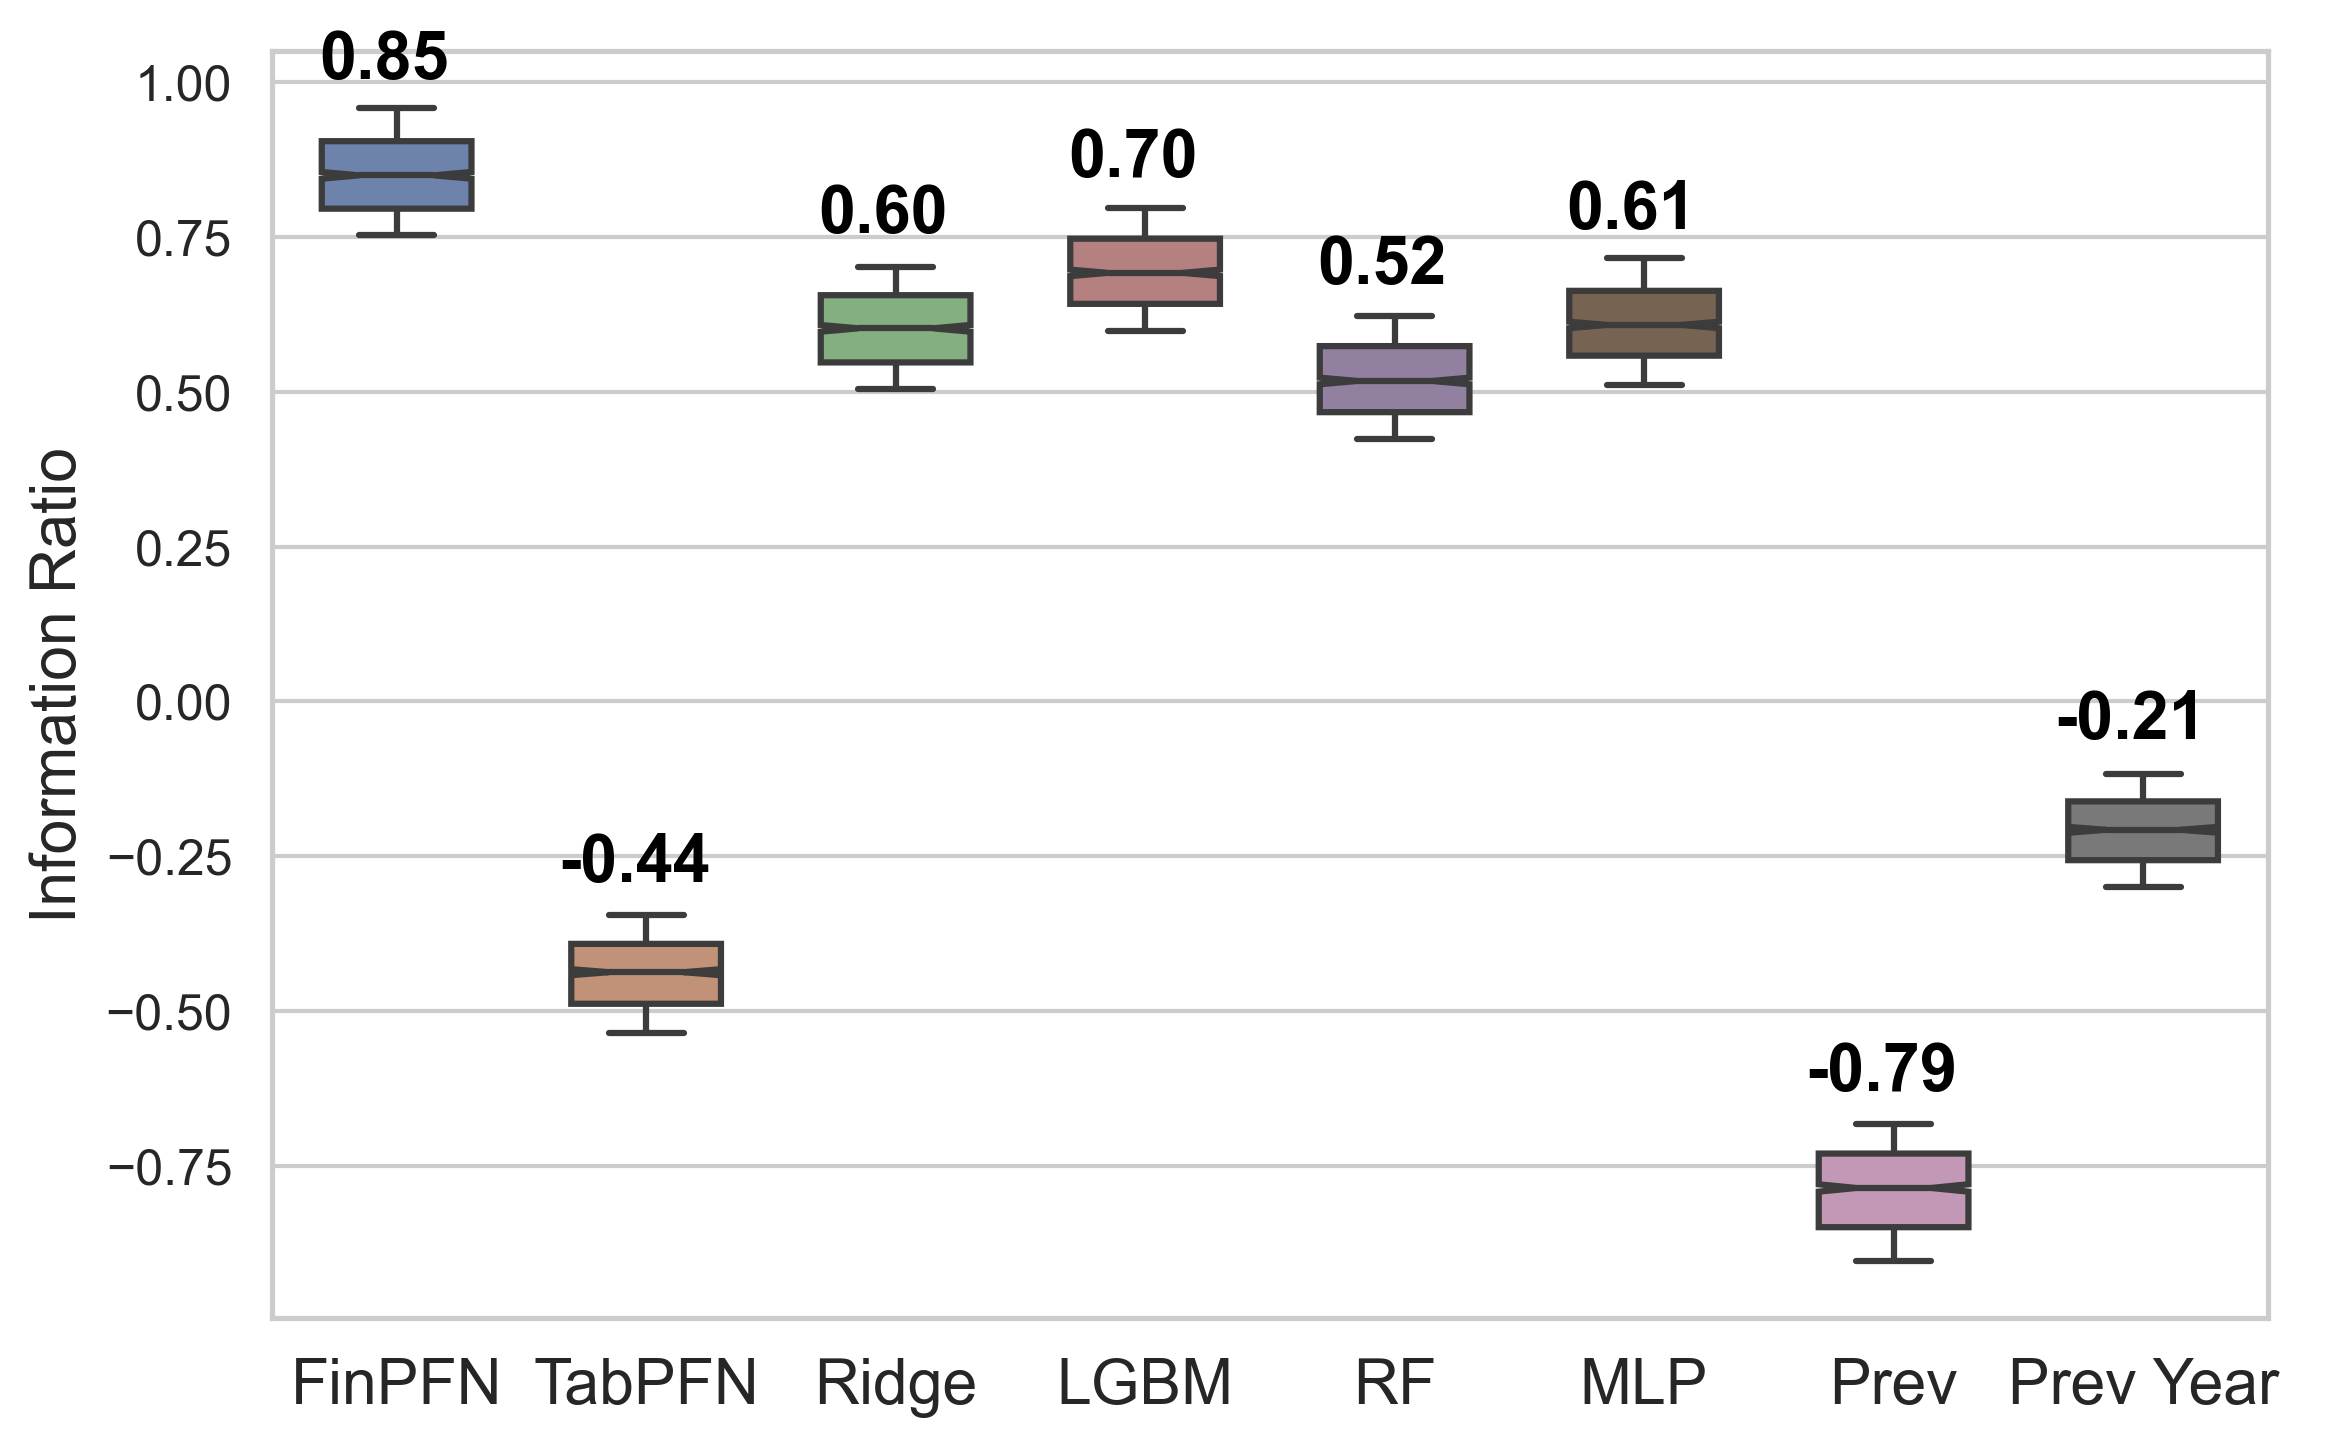

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme for cleaner aesthetics
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5), dpi=300)

# Create the boxplot with custom palette and style enhancements
ax = sns.boxplot(
    data=ir_df,
    whis=(10,90),
    orient="v",
    notch=True,
    showfliers=False,
    palette=sns.color_palette("muted", desat=0.6),  # Try "pastel", "Set3", "coolwarm", or a custom palette
    linewidth=1.5,
    width=0.6,
#     showmeans=True, meanline=True,
#     meanprops={
#     'color': 'red',
#     'linestyle': '--',
#     'linewidth': 1.5  # << Make the mean line thicker here
#     }
)

# Axis labels and ticks
plt.ylabel("Information Ratio", fontsize=15)
# plt.xlabel("Methods", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)

# Highlight reference lines
# plt.axhline(result_corr["finpfn"].median(), color="skyblue", linestyle="--", linewidth=1.2, label="finpfn median")
# plt.axhline(0, color="gray", linestyle="--", linewidth=1, label="corr = 0")

# Extract top of each box (Q3)
for i, patch in enumerate(ax.patches):
    # Get the path of the box
    path = patch.get_path()
    vertices = path.vertices
    box = patch.get_patch_transform().transform(vertices)

    # x is center of box, y_top is Q3
    x = box[:, 0].mean()
    y_top = box[:, 1].max()

    ax.text(x, y_top+0.08, f"{ir_df.mean().iloc[i]:.2f}", ha='center', va='bottom', fontsize=16, color='black', fontweight='bold')

# Add legend outside the plot for clarity
plt.legend(fontsize=10, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

# plt.ylim(-0.15,0.1)
# Add tight layout to avoid clipping
plt.tight_layout()

plt.show()


# Performance during regime changes

In [2499]:
regimes = [
    ["2022-03-11 00:00:00", "2022-03-12 00:00:00"],
["2022-03-14 00:00:00", "2022-03-15 00:00:00"],
["2022-04-08 00:00:00", "2022-04-09 00:00:00"],
["2022-04-22 00:00:00", "2022-04-23 00:00:00"],
["2022-08-01 00:00:00", "2022-08-02 00:00:00"],
["2022-10-21 00:00:00", "2022-10-22 00:00:00"],
["2022-10-28 00:00:00", "2022-10-29 00:00:00"]
          ]

In [2501]:
# Combine boolean masks using OR
mask = pd.Series(False, index=result_corr.index)
for start, end in regimes:
    mask |= result_corr.index.to_series().between(start, end)

# Slice the DataFrame
result_corr_filtered = result_corr.loc[mask]

In [2504]:
result_corr_filtered#.shape

,FinPFN,TabPFN,Ridge,LGBM,RF,MLP,Prev,Prev Year
date,,,,,,,,
2022-03-11 09:30:00,0.038361,-0.045393,0.080237,0.075053,0.107124,0.092104,-0.035979,-0.084253
2022-03-14 09:30:00,0.029589,-0.029016,-0.016383,-0.004526,-0.057422,-0.010802,-0.015616,-0.056576
2022-04-08 09:30:00,0.058760,0.003253,-0.065828,0.022088,-0.007342,-0.066382,0.026564,0.059559
2022-04-22 09:30:00,0.024652,-0.026923,0.062053,0.032237,0.065057,0.031472,-0.052303,0.130495
2022-08-01 09:30:00,0.096025,-0.101412,0.057865,0.050324,0.053431,0.074490,-0.136994,-0.057646
2022-10-21 09:30:00,0.042815,-0.117639,0.047149,0.033427,0.060437,0.072755,-0.145641,0.093233
2022-10-28 09:30:00,0.077281,-0.085018,-0.004931,-0.004052,-0.016452,0.008371,-0.044044,-0.037698


In [2513]:
result_corr_filtered.mean()/result_corr_filtered.std()

FinPFN       1.998110
TabPFN      -1.290765
Ridge        0.432121
LGBM         1.025743
RF           0.508825
MLP          0.511755
Prev        -0.920665
Prev Year    0.078601
dtype: float64

In [2514]:
import numpy as np

seed = 0  # fixed seed for reproducibility
rng = np.random.RandomState(seed)

ir_df2 = pd.DataFrame()
for i in range(1000):
    ic = result_corr_filtered.sample(10, replace=True, random_state=rng.randint(0, 1_000_000))
    ir = ic.mean()/ic.std()
    ir_df2[i] = ir
ir_df2 = ir_df2.T

In [2515]:
ir_df2.mean()

FinPFN       2.268877
TabPFN      -1.437244
Ridge        0.518706
LGBM         1.161164
RF           0.580621
MLP          0.606181
Prev        -1.026065
Prev Year    0.063854
dtype: float64

In [2487]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12  # Sets default font size to 12pt

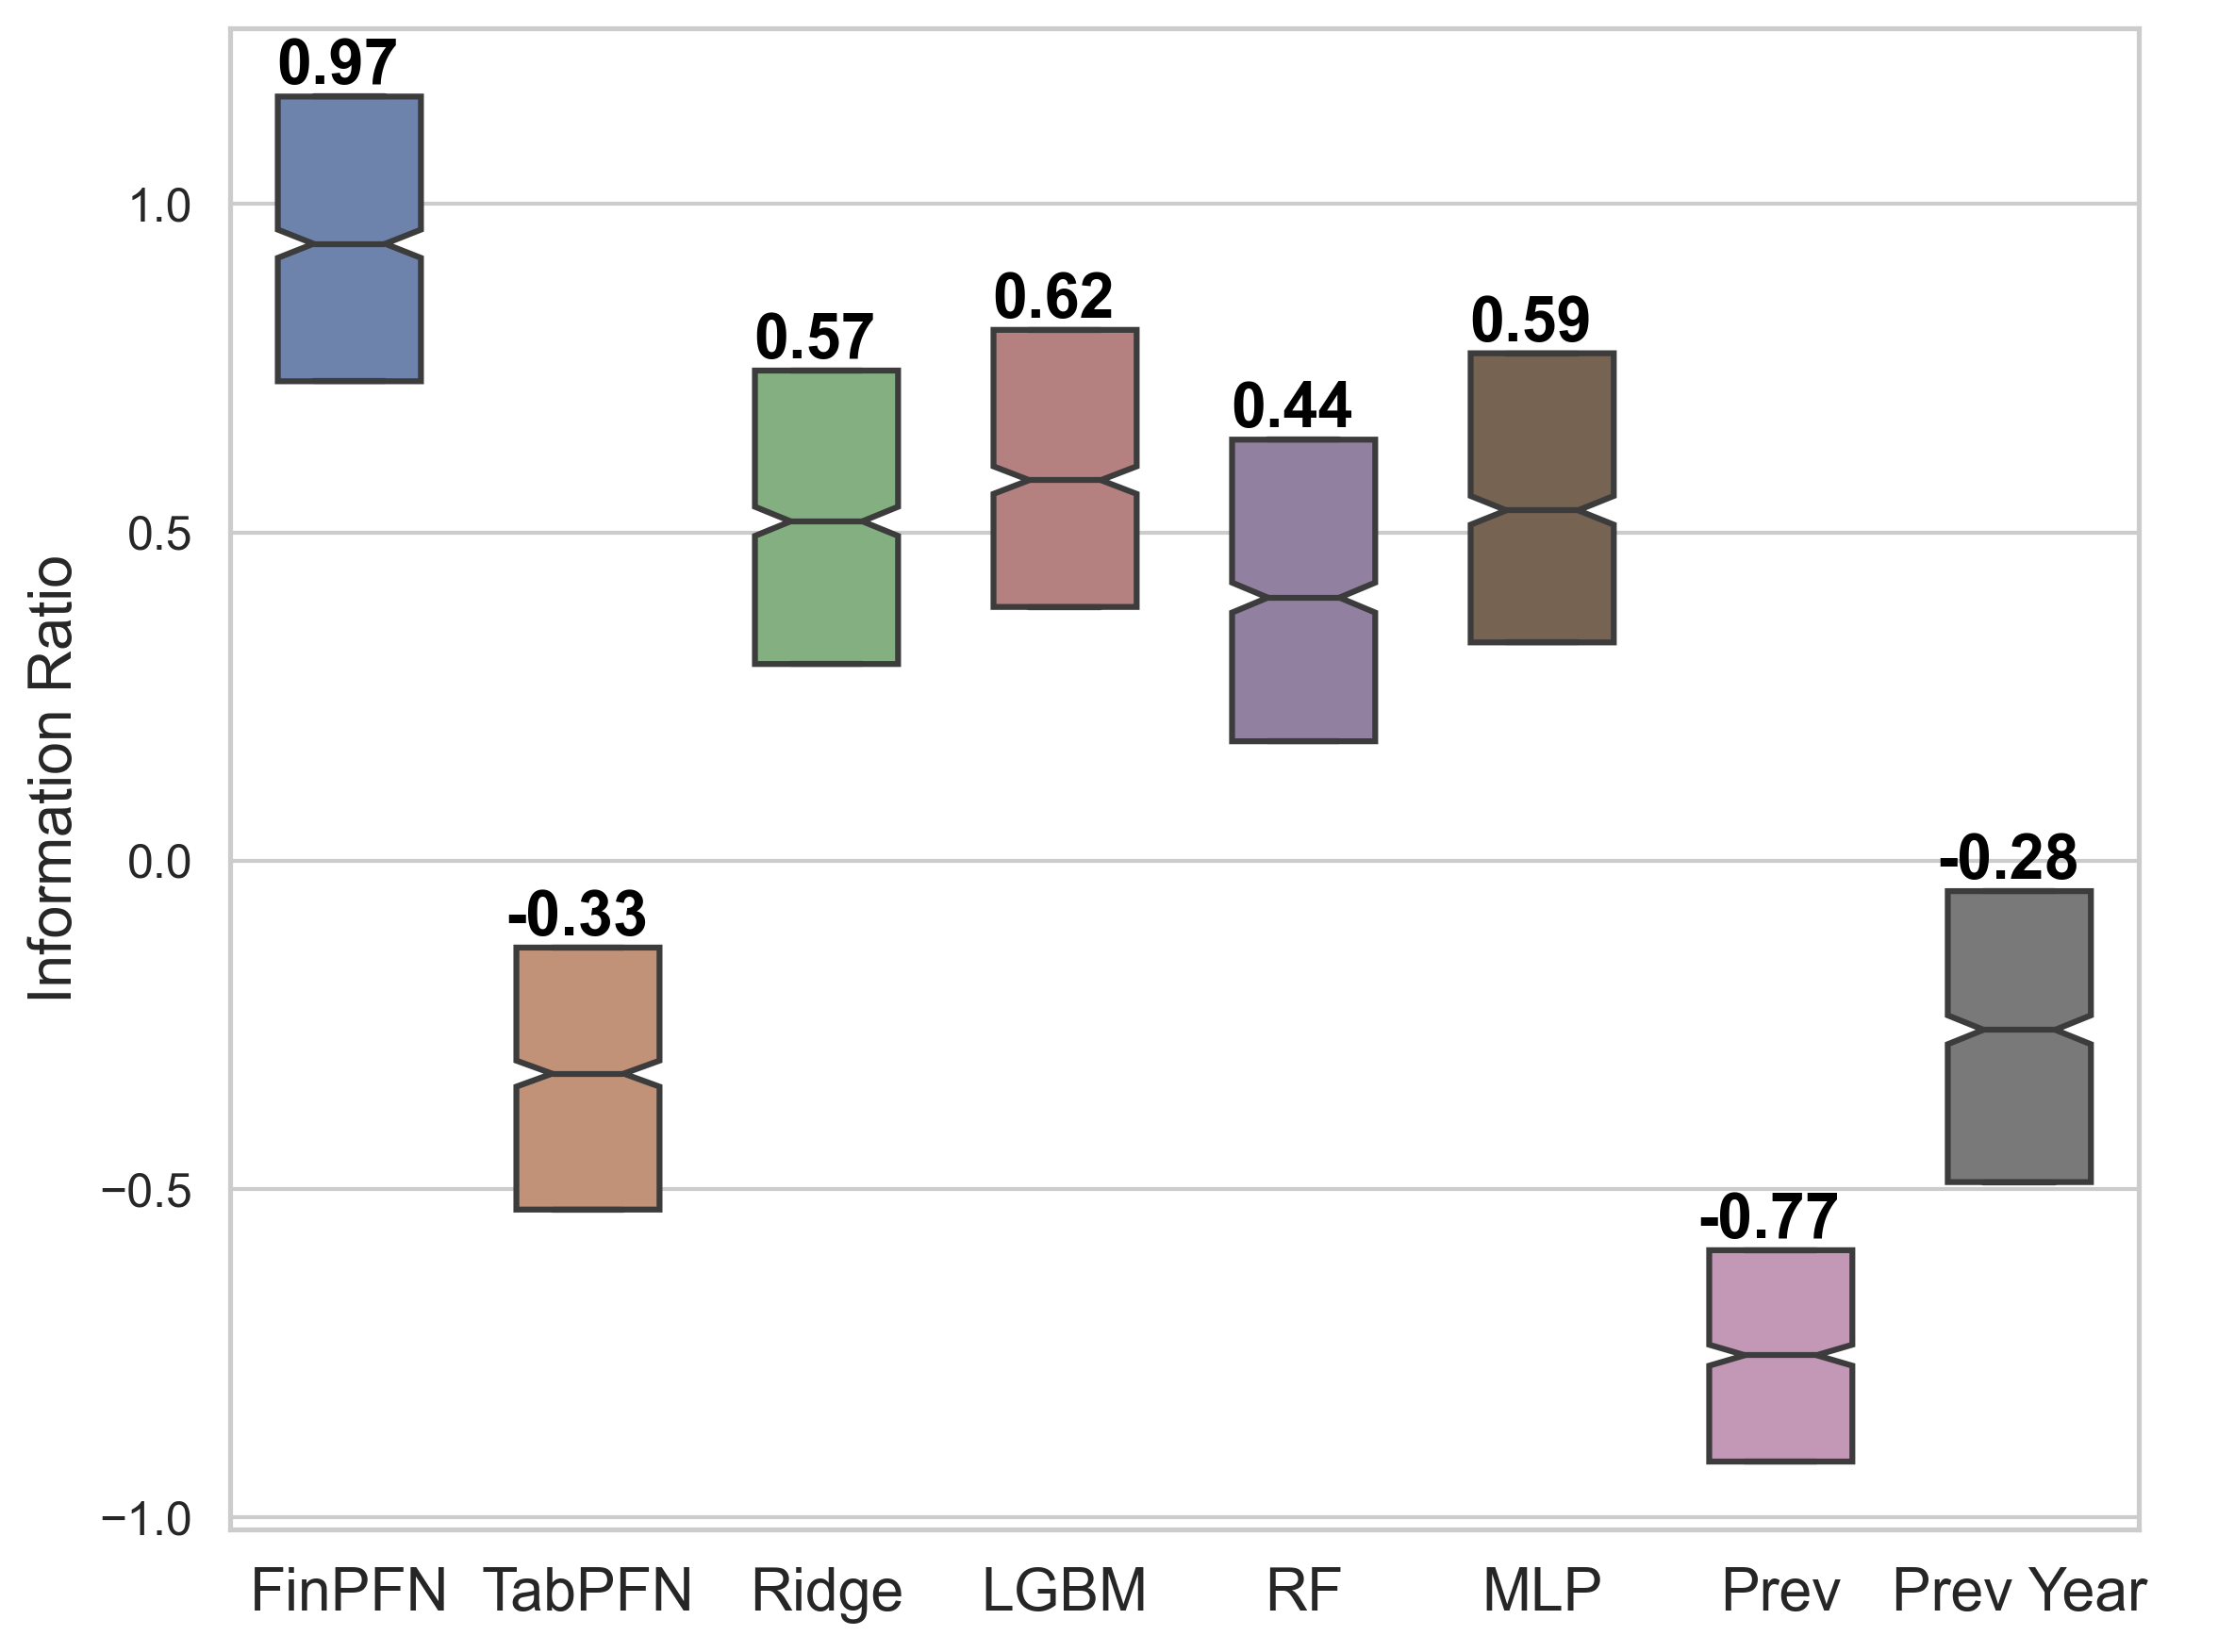

In [2488]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme for cleaner aesthetics
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6), dpi=300)

# Create the boxplot with custom palette and style enhancements
ax = sns.boxplot(
    data=ir_df2,
    whis=0, 
    orient="v",
    notch=True,
    showfliers=False,
    palette=sns.color_palette("muted", desat=0.6),  # Try "pastel", "Set3", "coolwarm", or a custom palette
    linewidth=1.5,
    width=0.6,
#     showmeans=True, meanline=True,
#     meanprops={
#     'color': 'red',
#     'linestyle': '--',
#     'linewidth': 1.5  # << Make the mean line thicker here
#     }
)

# Axis labels and ticks
plt.ylabel("Information Ratio", fontsize=15)
# plt.xlabel("Methods", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)

# Highlight reference lines
# plt.axhline(result_corr["finpfn"].median(), color="skyblue", linestyle="--", linewidth=1.2, label="finpfn median")
# plt.axhline(0, color="gray", linestyle="--", linewidth=1, label="corr = 0")

# ir_filtered = result_corr_filtered.mean() / result_corr_filtered.std()

# Extract top of each box (Q3)
for i, patch in enumerate(ax.patches):
    # Get the path of the box
    path = patch.get_path()
    vertices = path.vertices
    box = patch.get_patch_transform().transform(vertices)

    # x is center of box, y_top is Q3
    x = box[:, 0].mean()
    y_top = box[:, 1].max()

    ax.text(x, y_top, f"{ir_df2.mean().iloc[i]:.2f}", ha='center', va='bottom', fontsize=16, color='black', fontweight='bold')

# Add legend outside the plot for clarity
plt.legend(fontsize=10, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

# Add tight layout to avoid clipping
plt.tight_layout()
# plt.ylim(-0.1, 0.1)

plt.show()


In [1589]:
# information ratio
ir_filtered = result_corr_filtered.mean() / result_corr_filtered.std()
ir_filtered

Finpfn       0.891101
TabPFN      -0.330891
Ridge        0.529072
LGBM         0.501555
RF           0.353451
MLP          0.522998
Prev        -0.781735
Prev_year   -0.165712
dtype: float64

# Portfolio performance

In [2656]:
result_df_finpfn = result_df[["date", "id", "target", "finpfn_median_pred"]].copy()
# Rank predictions into 10 buckets by date using qcut
result_df_finpfn["rank"] = (
    result_df_finpfn.groupby("date")["finpfn_median_pred"]
    .transform(lambda x: pd.qcut(x, q=10, labels=False) + 1)
)
result_df_finpfn = result_df_finpfn.merge(test_set[["date", "id", "target"]].rename(columns={"target": "return"}), on=["date", "id"])
# Subtract daily mean return to get relative return
result_df_finpfn["ex_return"] = (
    result_df_finpfn["return"] - result_df_finpfn.groupby("date")["return"].transform("mean")
)

In [1697]:
result_df_finpfn

,date,id,target,finpfn_mean_pred,rank,return,ex_return
0,2022-01-05 09:30:00,000008.XSHE,0.690989,-0.023103,7,1.291904,1.230196
1,2022-01-06 09:30:00,000008.XSHE,0.464909,-0.112872,1,0.842518,0.952723
2,2022-01-07 09:30:00,000008.XSHE,0.444850,-0.091071,1,1.003175,0.986286
3,2022-01-10 09:30:00,000008.XSHE,-0.876453,-0.082258,1,-1.707838,-1.538716
4,2022-01-11 09:30:00,000008.XSHE,-1.204356,-0.034839,6,-2.158409,-2.360208
...,...,...,...,...,...,...,...
184476,2023-03-28 09:30:00,688819.XSHG,-0.195127,-0.053097,4,-0.187064,-0.195202
184477,2023-03-29 09:30:00,688819.XSHG,-0.127621,-0.058165,3,-0.375537,-0.287728
184478,2023-03-30 09:30:00,688819.XSHG,-0.529538,-0.030292,7,-0.972946,-0.874427
184479,2023-03-31 09:30:00,688819.XSHG,0.457559,-0.019577,8,0.790947,0.777998


In [2657]:
ret = result_df_finpfn.groupby(["date", "rank"])["ex_return"].mean().unstack().fillna(0)
port = ret.cumsum()
# port.plot(figsize=(12,7))

In [2658]:
port.iloc[-1]

rank
1    -41.990077
2    -16.685467
3     -9.511100
4     -5.219686
5      1.776085
6      1.107230
7     13.316321
8     13.968397
9     15.324738
10    28.037808
Name: 2023-04-03 09:30:00, dtype: float64

In [2659]:
port.iloc[-1][10]-port.iloc[-1][1]

np.float64(70.02788529283185)

In [2679]:
sharpe = ret.mean() / ret.std() * np.sqrt(240)
sharpe, sharpe[10] - sharpe[1]

(rank
 1    -4.751747
 2    -2.897933
 3    -2.116281
 4    -1.105464
 5     0.375050
 6     0.248503
 7     3.111166
 8     3.047406
 9     3.448469
 10    5.093916
 dtype: float64,
 np.float64(9.845662894526958))

In [2663]:
result_df_rf = result_df[["date", "id", "target", "lgbm_pred"]].copy()
# Rank predictions into 10 buckets by date using qcut
result_df_rf["rank"] = (
    result_df_rf.groupby("date")["lgbm_pred"]
    .transform(lambda x: pd.qcut(x.rank(method="dense"), q=10, labels=False) + 1)
)
result_df_rf = result_df_rf.merge(test_set[["date", "id", "target"]].rename(columns={"target": "return"}), on=["date", "id"])
# Subtract daily mean return to get relative return
result_df_rf["ex_return"] = (
    result_df_rf["return"] - result_df_rf.groupby("date")["return"].transform("mean")
)

In [2664]:
ret_rf = result_df_rf.groupby(["date", "rank"])["ex_return"].mean().unstack().fillna(0)
port_rf = ret_rf.cumsum()
# port_rf.plot(figsize=(12,7))

In [2682]:
sharpe_rf = ret_rf.mean()/ ret_rf.std()*np.sqrt(240)
sharpe_rf, sharpe_rf[10] - sharpe_rf[1]

(rank
 1    -4.179116
 2    -2.613458
 3    -1.470129
 4     0.345022
 5    -1.620938
 6     1.126878
 7     1.673711
 8     3.433294
 9     2.625524
 10    3.125742
 dtype: float64,
 np.float64(7.3048578461517675))

In [2421]:
port_rf.iloc[-1]

rank
1    -36.844161
2    -16.977569
3    -10.100501
4      2.421675
5     -5.164950
6      4.120158
7      7.803573
8     16.454743
9     14.772624
10    23.514408
Name: 2023-04-03 09:30:00, dtype: float64

In [2446]:
port_rf.iloc[-1][10]-port_rf.iloc[-1][1]

np.float64(60.358568383262366)

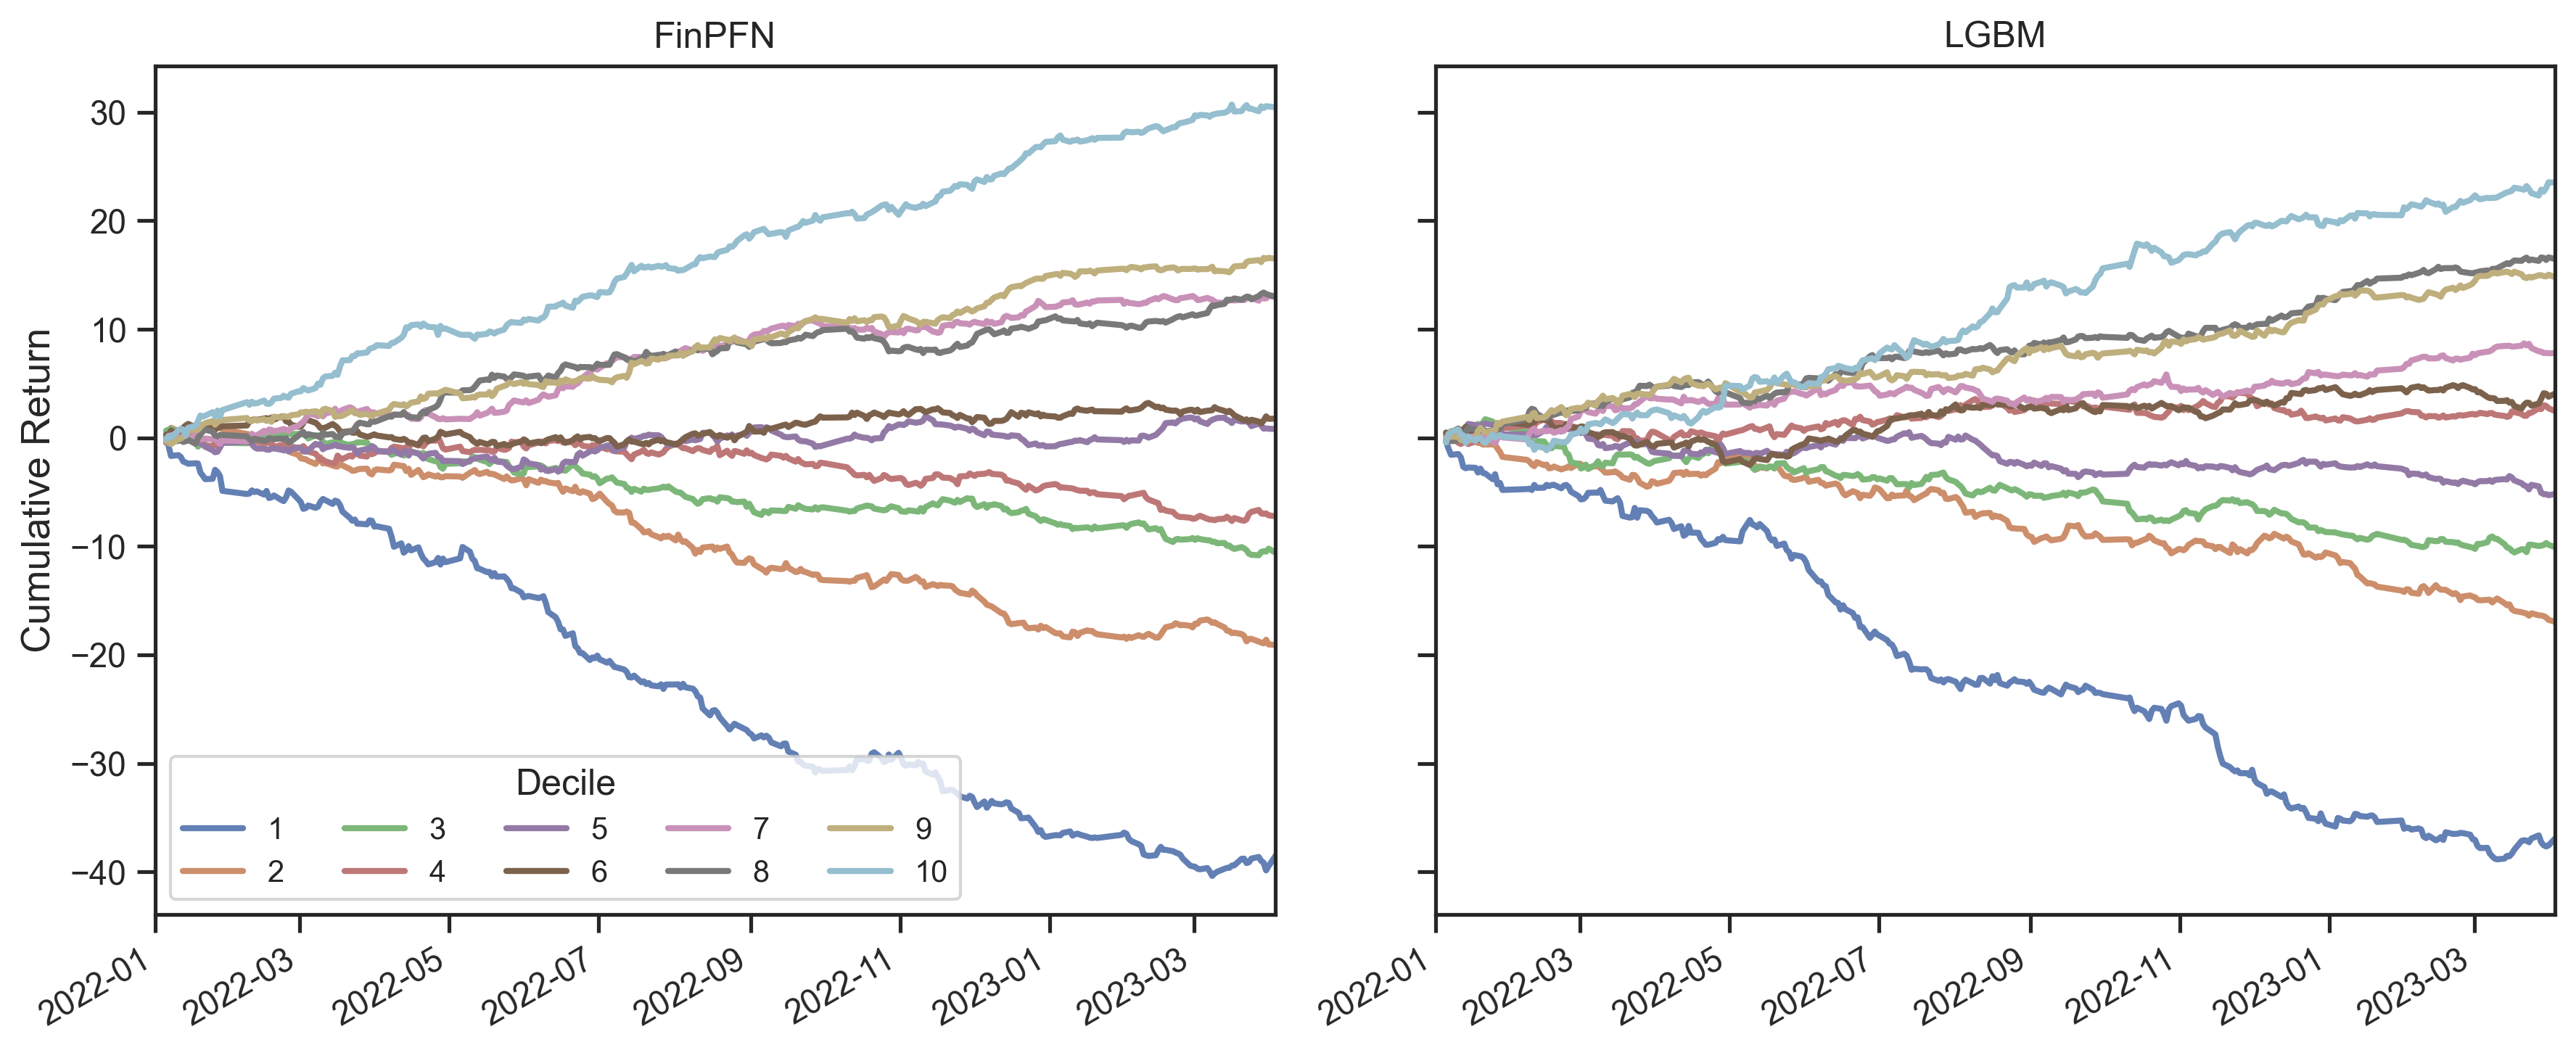

In [2476]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme for cleaner aesthetics
sns.set_style("ticks")
colors = sns.color_palette("muted", desat=0.6)

# Create 1x2 subplot with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300, sharey=True)

# First subplot
port.plot(ax=axes[0], linewidth=2, color=colors)
axes[0].legend(loc='lower left', title='Decile', ncol=5, fontsize=10)
axes[0].set_ylabel('Cumulative Return', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_xlim("2022-01-01", "2023-04-03")
axes[0].set_title("FinPFN")  # Optional

# Second subplot
port_rf.plot(ax=axes[1], linewidth=2, color=colors)
# axes[1].legend(loc='lower left', title='Decile', ncol=5, fontsize=10)
axes[1].set_xlabel('')
axes[1].legend().set_visible(False)
axes[1].set_xlim("2022-01-01", "2023-04-03")
axes[1].set_title("LGBM")  # Optional

plt.tight_layout()
plt.show()
